# Librerías

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json

# Diccionario

In [56]:
import pandas as pd

# Leer el archivo Excel
df_diccionarios = pd.read_excel('./files/envi_2020_fd.xlsx')

# Inicializar el diccionario para almacenar las secciones y preguntas
diccionario_secciones = {}
seccion_actual = None

# Recorrer el DataFrame fila por fila
for index, row in df_diccionarios.iterrows():
    # Identificar las filas que contienen 'SECCIÓN'
    if isinstance(row[1], str) and 'SECCIÓN' in row[1]:
        seccion_actual = row[1].strip()
        diccionario_secciones[seccion_actual] = []
    # Si estamos dentro de una sección, añadir las preguntas y nemónicos, excluyendo los encabezados y [1] y [2]
    elif seccion_actual and isinstance(row[1], str) and row[1].strip() not in ["Pregunta", "Nemónico", "[1]", "[2]"]:
        pregunta = row[1].strip() if isinstance(row[1], str) else ''
        nemonico = row[2].strip() if isinstance(row[2], str) else ''
        if pregunta and nemonico:
            diccionario_secciones[seccion_actual].append((pregunta, nemonico))

# Guardar el diccionario en un archivo JSON
output_file = './processed_files/diccionario_secciones.json'
with open(output_file, 'w', encoding='utf-8') as f:
    json.dump(diccionario_secciones, f, ensure_ascii=False, indent=4)

print(f"El diccionario ha sido guardado en {output_file}")


El diccionario ha sido guardado en ./processed_files/diccionario_secciones.json


---

# Archivos importantes

In [57]:
# Ruta archivos
ruta = './files/envi_2020_base_de_datos_csv/Bases de datos'
# Archivos
df_TVIVIENDA = pd.read_csv(ruta + '/TVIVIENDA.csv')
df_TSDEM = pd.read_csv(ruta + '/TSDEM.csv')
df_TVIVIENDA.shape

(55147, 416)

---

# Delimitación de Nan's

In [58]:
missing_percentage = df_TVIVIENDA.isnull().mean()*100
columns_to_keep = missing_percentage[missing_percentage < 70].index

df_TVIVIENDA = df_TVIVIENDA[columns_to_keep]

# Guardar el nuevo DataFrame sin columnas con exceso de NaNs
df_TVIVIENDA.to_csv('./processed_files/TVIVIENDA_clean.csv', index=False)

---

# Entendimiento de los datos

In [59]:
df_TVIVIENDA = pd.read_csv('./processed_files/TVIVIENDA_clean.csv')

# Leer el diccionario de secciones
with open('./processed_files/diccionario_secciones.json', 'r', encoding='utf-8') as f:
    diccionario_secciones = json.load(f)

# Revisar que preguntas están en el DataFrame
preguntas = []
for seccion, preguntas_seccion in diccionario_secciones.items():
    for pregunta, nemonico in preguntas_seccion:
        if nemonico in df_TVIVIENDA.columns:
            preguntas.append((seccion, pregunta, nemonico))

# Guardar las preguntas en un archivo CSV
df_preguntas = pd.DataFrame(preguntas, columns=['Sección', 'Pregunta', 'Nemónico'])
df_preguntas.to_excel('./processed_files/preguntas.xlsx', index=False)


---

# Matriz de correlación

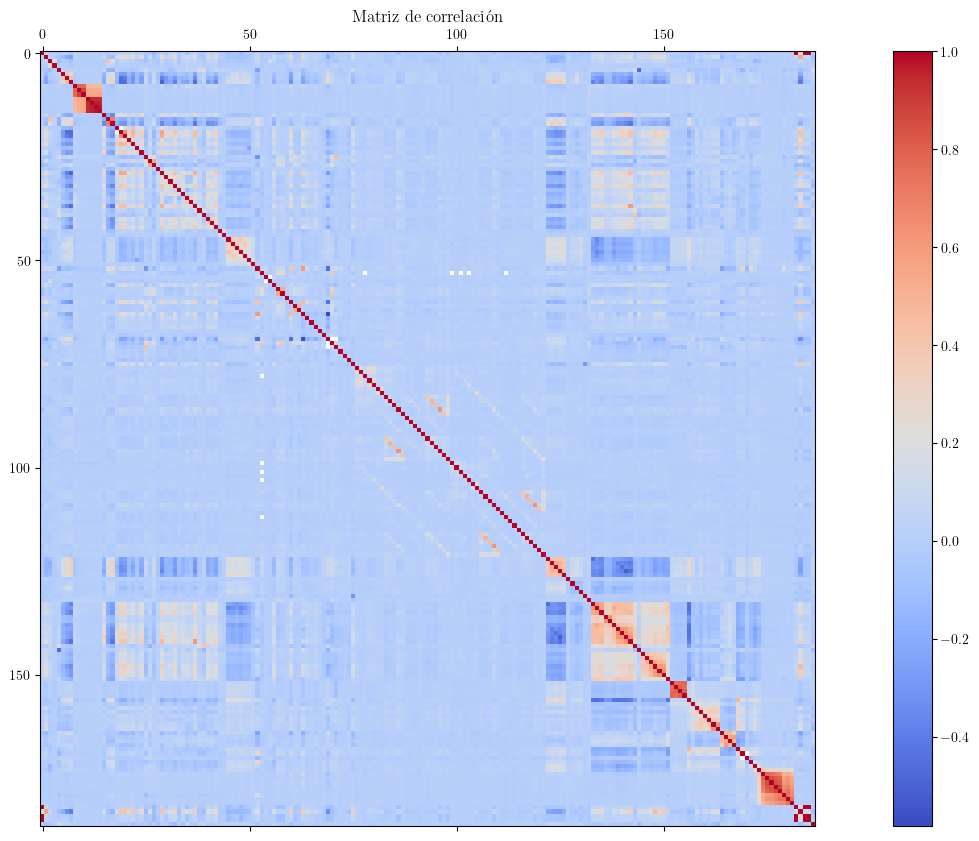

In [60]:
# Cargar los datos
data = pd.read_csv('./processed_files/TVIVIENDA_clean.csv')

# Realizar una matriz de correlación
correlation_matrix = data.corr()

# Graficar la matriz de correlación
plt.figure(figsize=(20, 10))
plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.title('Matriz de correlación')
plt.show()

---

# Análisis topológico de todas las variables

Diagrama de persistencia para las variables: ['P4_4', 'P4_5', 'P4_6']


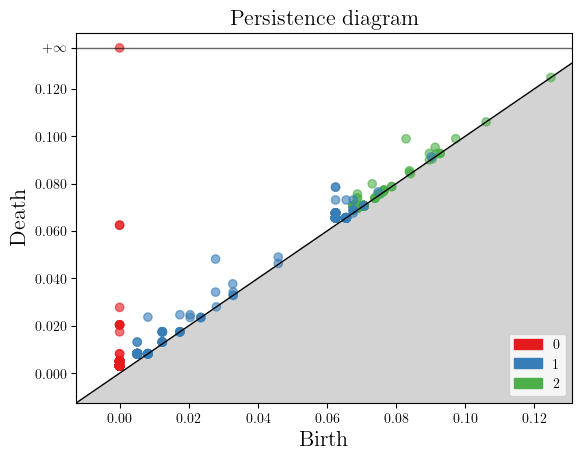

Diagrama de persistencia para las variables: ['P4_10A', 'P6_8']


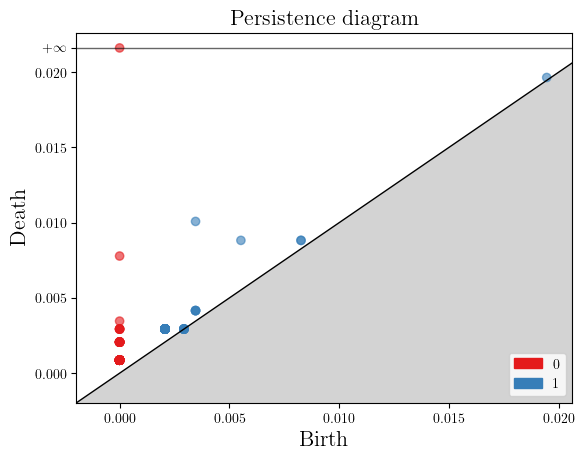

Diagrama de persistencia para las variables: ['P4_14', 'P4_15', 'P4_17']


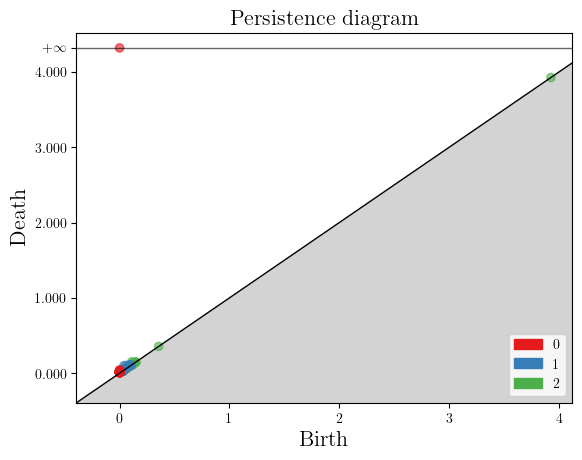

Diagrama de persistencia para las variables: ['P4_19_1', 'P5_13_2', 'P5_13_3', 'P5_25_1']


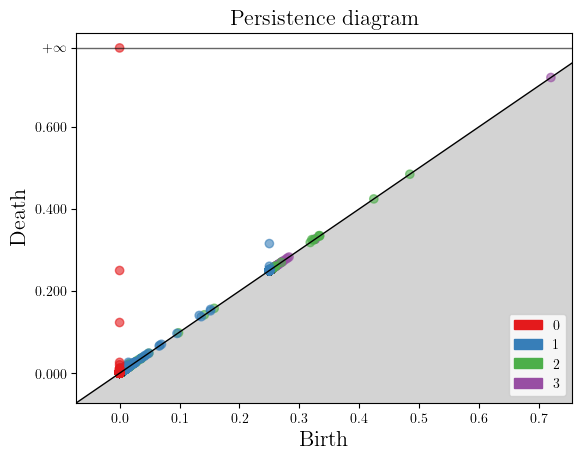

Diagrama de persistencia para las variables: ['P4_21_1', 'P6_8']


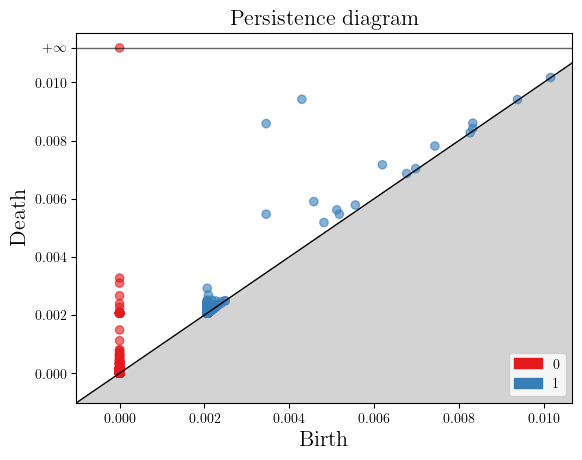

Diagrama de persistencia para las variables: ['P6_8', 'P6_11']


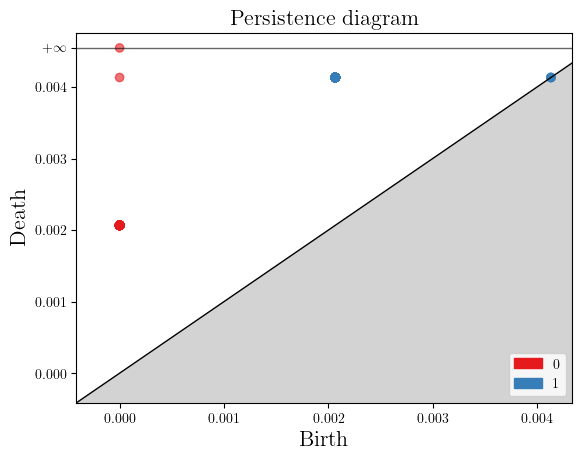

Diagrama de persistencia para las variables: ['P5_2', 'P5_9']


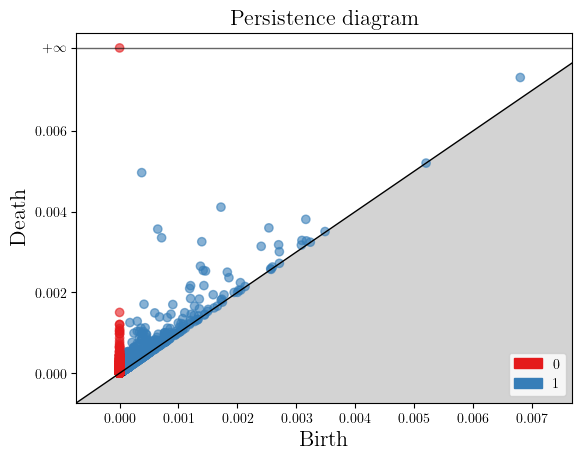

In [103]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import gudhi as gd
import itertools
import plotly.graph_objects as go

# Cargar los datos
data = pd.read_csv('./processed_files/TVIVIENDA_clean.csv')

# Listas de variables por categoría
variables_materiales = ['P4_4', 'P4_5', 'P4_6']
variables_espacio = ['P4_10A', 'P6_8']
variables_servicios = ['P4_14', 'P4_15', 'P4_17']
variables_antiguedad = ['P4_19_1', 'P5_13_2', 'P5_13_3', 'P5_25_1']
variables_dimensiones = ['P4_21_1', 'P6_8']
variables_satisfaccion = ['P6_8', 'P6_11']
variables_tenencia = ['P5_2', 'P5_9']

# Combinar todas las listas de variables en una sola lista
all_variables = [variables_materiales, variables_espacio, variables_servicios, variables_antiguedad, variables_dimensiones, variables_satisfaccion, variables_tenencia]

# # Crear todas las combinaciones posibles de variables
# all_combinations = [combo for sublist in all_variables for combo in itertools.combinations(sublist, 2)]

# Procesar cada combinación de variables
for variables in all_variables:
    selected_data = data[list(variables)].copy()

    # Limpieza de datos: Imputar valores faltantes con la moda para datos categóricos
    for column in selected_data.columns:
        selected_data[column].fillna(selected_data[column].mode()[0], inplace=True)

    # Convertir datos categóricos a codificación numérica y a numéricos
    selected_data = pd.get_dummies(selected_data)
    le = LabelEncoder()
    for column in selected_data.columns:
        selected_data[column] = le.fit_transform(selected_data[column])

    # Normalizar los datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_normalized = scaler.fit_transform(selected_data)

    # Utilizar AlphaComplex para construir el complejo simplicial
    alpha_complex = gd.AlphaComplex(points=data_normalized)
    simplex_tree = alpha_complex.create_simplex_tree()
    persistence_diagram = simplex_tree.persistence()

    # Visualizar el diagrama de persistencia
    print(f"Diagrama de persistencia para las variables: {variables}")
    gd.plot_persistence_diagram(persistence_diagram)
    plt.show()


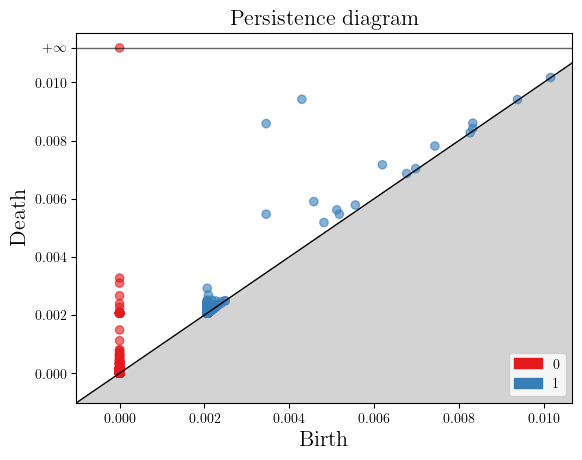

Betti numbers: [1, 0]


In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import plotly.graph_objects as go
import gudhi as gd

# Cargar los datos
data = pd.read_csv('./processed_files/TVIVIENDA_clean.csv')


variables = variables_dimensiones
selected_data = data[variables].copy()

# Limpieza de datos: Imputar valores faltantes con la moda para datos categóricos
for column in selected_data.columns:
    selected_data[column].fillna(selected_data[column].mode()[0], inplace=True)

# # Limpieza de datos: Remover valores que estén a más de 3 desviaciones estándar de la media
# for column in selected_data.columns:
#     selected_data = selected_data[np.abs(selected_data[column] - selected_data[column].mean()) <= (10 * selected_data[column].std())]

# Convertir datos categóricos a codificación numérica
selected_data = pd.get_dummies(selected_data)

# Convertir datos categóricos a numéricos
le = LabelEncoder()
for column in selected_data.columns:
    selected_data[column] = le.fit_transform(selected_data[column])

# Normalizar los datos
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(selected_data)
# Utilizar AlphaComplex para construir el complejo simplicial
alpha_complex = gd.AlphaComplex(points=data_normalized)
simplex_tree = alpha_complex.create_simplex_tree()
persistence_diagram = simplex_tree.persistence()
# Crea una figura y un eje
fig, ax = plt.subplots()

# Dibuja el diagrama de persistencia
gd.plot_persistence_diagram(persistence_diagram, axes=ax)

# Define la región de interés
birth_min, birth_max = 0.06, 0.08
death_min, death_max = 0.055, 0.085

# Dibuja un rectángulo para resaltar la región
from matplotlib.patches import Rectangle
rect = Rectangle((birth_min, death_min), birth_max-birth_min, death_max-death_min, fill=False, color='red', linewidth=2)
ax.add_patch(rect)

# Cambia el color de los puntos dentro de la región
for birth, death in persistence_diagram:
    if birth_min <= birth <= birth_max and death_min <= death <= death_max:
        ax.plot(birth, death, 'o', color='magenta', markersize=8)

# Mostrar la figura
plt.show()

# Obtener Betti numbers
betti_numbers = simplex_tree.persistent_betti_numbers(0, np.inf)
print("Betti numbers:", betti_numbers)

In [107]:
# Obtain questions with the nemónico
questions = []
for variable in variables:
    for seccion, preguntas_seccion in diccionario_secciones.items():
        for pregunta, nemonico in preguntas_seccion:
            if nemonico == variable:
                questions.append(pregunta)

# Imprimir las preguntas
print(questions[0])

4.21 ¿Cuántos metros de construcción tiene esta vivienda?


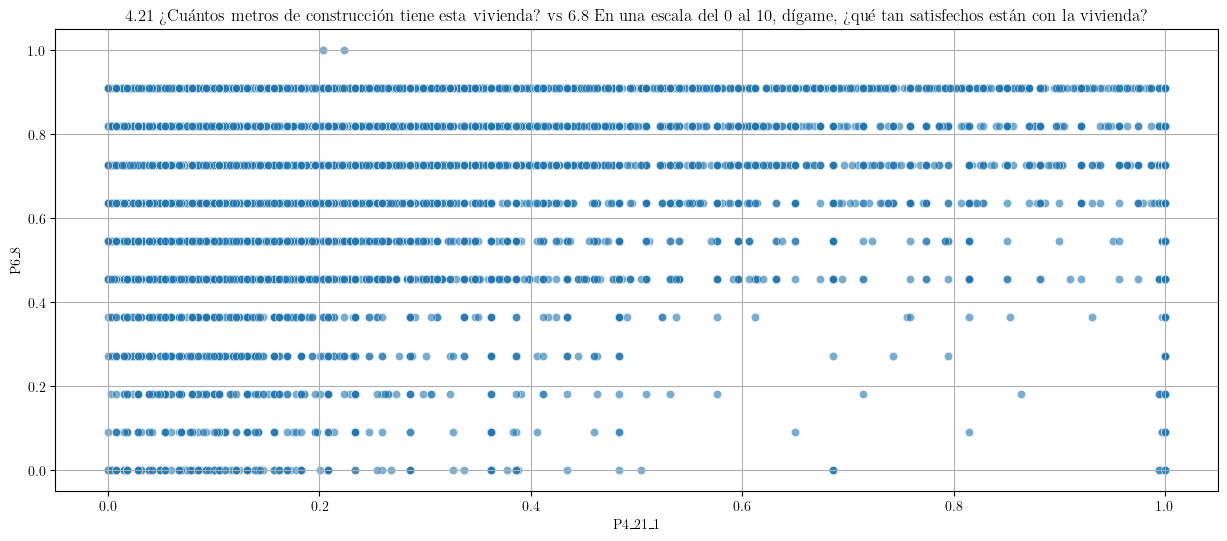

In [108]:
# Crear el scatter plot
plt.figure(figsize=(15, 6))
plt.scatter(data_normalized[:, 0], data_normalized[:, 1], alpha=0.6, edgecolors='w', linewidth=0.5)
plt.title(f'{questions[0]} vs {questions[1]}')
plt.xlabel(variables[0])
plt.ylabel(variables[1])
plt.grid(True)
plt.show()

In [95]:
# Extraer los triángulos del esqueleto
triangles = np.array([s[0] for s in simplex_tree.get_skeleton(2) if len(s[0]) == 3])

# Crear un array de puntos para los triángulos
points_array = data_normalized[np.unique(triangles)]
X, Y, Z = points_array[:, 0], points_array[:, 1], points_array[:, 2]

# Obtener triángulos como índices relativos a los puntos únicos usados
tri_indices = {idx: i for i, idx in enumerate(np.unique(triangles))}
triangles_indices = np.array([[tri_indices[idx] for idx in tri] for tri in triangles])

# Graficar el complejo
fig = go.Figure(data=[
    go.Mesh3d(
        x=X,
        y=Y,
        z=Z,
        i=triangles_indices[:, 0],
        j=triangles_indices[:, 1],
        k=triangles_indices[:, 2],
        color='blue',
        opacity=0.05
    )
])

fig.update_layout(
    title = 'Triangulación de la nube de puntos',
    width=500,
    height=500,
    scene=dict(
        xaxis=dict(nticks=4, range=[-1,1]),
        yaxis=dict(nticks=4, range=[-1,1]),
        zaxis=dict(nticks=4, range=[-1,1])
    )
)
fig.show()

---